## Betabinomial likelihood ratio test

In [33]:
import torch
import sys
import pyro

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

import numpy as np

from pooledQTL import deconvolve, beta_model, gaussian_model, io_utils, asb_data

from importlib import reload

from pathlib import Path

from pooledQTL import bb_lrt

input_file = "../results/HNRNPA1/beta_struct_rep0.tsv.gz"
output_file = "../results/HNRNPA1/beta_struct_bblrt_rep0.tsv.gz"
conc = 300.
p_threshold = 0.01

In [34]:
data = pd.read_csv(input_file, sep = "\t", index_col = False)

In [35]:
data

,contig,position_hg19,variantID,refAllele,altAllele,position,refCount_input,altCount_input,totalCount_input,pred_ratio,...,altCount_IP,totalCount_IP,shrunk_input_logratio,ase_loc,ase_sd,ase_q,shrunk_IP_logratio,asb_loc,asb_sd,asb_q
0,chr10,294953,rs1017361,A,G,249013,18,109,127,0.925054,...,220,233,2.217722,-0.295365,0.211430,0.081209,2.581102,0.363381,0.339869,0.142494
1,chr10,320954,rs10903832,A,G,275014,98,24,122,0.191076,...,44,201,-1.379707,0.063327,0.193570,0.371776,-1.320950,0.058757,0.340416,0.431481
2,chr10,323034,rs17158753,G,A,277094,71,7,78,0.107493,...,17,83,-2.064728,0.051884,0.226532,0.409420,-1.672308,0.392419,0.241237,0.051901
3,chr10,323283,rs3740304,A,G,277343,60,52,112,0.602444,...,52,74,0.248630,-0.167028,0.135709,0.109203,0.498460,0.249830,0.199662,0.105418
4,chr10,326894,rs3125027,T,C,280954,20,6,26,0.180957,...,10,36,-1.211634,0.298241,0.207483,0.075299,-1.350553,-0.138918,0.334276,0.338859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261541,chr9,140995342,rs112278050,C,T,138100890,34,4,38,0.035813,...,1,37,-2.926193,0.366768,0.383999,0.169757,-3.177074,-0.250881,0.523417,0.315858
261542,chr9,141003534,rs9410071,G,A,138109082,17,15,32,0.613606,...,21,41,0.219482,-0.243013,0.165966,0.071566,0.264471,0.044989,0.208937,0.414757
261543,chr9,141005772,rs766373,A,G,138111320,16,27,43,0.647088,...,24,40,0.529351,-0.076912,0.231134,0.369659,0.426541,-0.102810,0.192120,0.296278
261544,chr9,141005820,rs766375,C,T,138111368,28,11,39,0.254254,...,9,45,-1.069229,0.006823,0.181701,0.485023,-1.217908,-0.148679,0.208110,0.237483


In [36]:
lrtp, lrtq, beta_full_input, beta_full_IP = bb_lrt.lrt(data, conc = float(conc))

(lrtq < 0.2).mean(), (lrtq < 0.2).sum()

(0.0, 0)

In [37]:
data["bb_lrt_p"] = lrtp
data.to_csv(output_file, index = False, sep = "\t")

(0.0, 1.0)

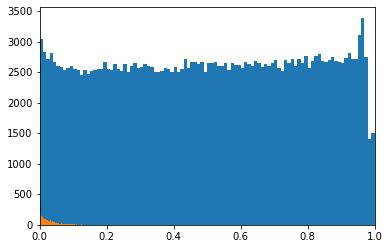

In [38]:
plt.hist(lrtp, 100)
_ = plt.hist(lrtp[beta_full_IP.isinf()], 100)
plt.xlim(0,1)

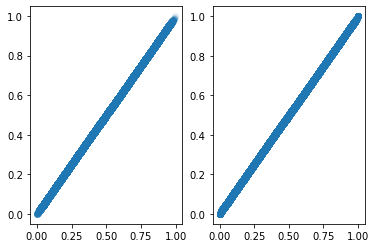

In [39]:
data["shrunk_input_ratio"]= beta_full_input.sigmoid().numpy()
data["shrunk_IP_ratio"] = beta_full_IP.sigmoid().numpy()

data["input_ratio"]= data.altCount_input / data.totalCount_input
data["IP_ratio"]= data.altCount_IP / data.totalCount_IP

plt.subplot(121)
plt.scatter(data.input_ratio, data.shrunk_input_ratio, alpha = 0.1)
plt.subplot(122)
plt.scatter(data.IP_ratio, data.shrunk_IP_ratio, alpha = 0.1)

Text(0.5, 1.0, '3036 (1.2%) significant (p < 0.01)')

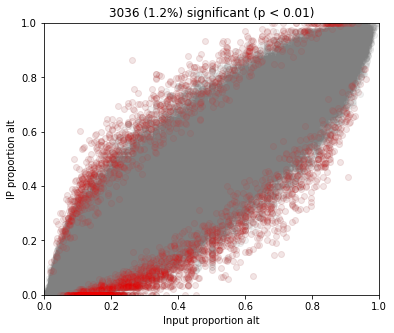

In [40]:
plt.figure(figsize = (6,5))
insig_alpha = 0.1; sig_alpha = 0.05

is_sig = data.bb_lrt_p < p_threshold

plt.scatter(data.shrunk_input_ratio, data.shrunk_IP_ratio, alpha=insig_alpha, color="gray")
dat_ss = data[is_sig]
plt.scatter(dat_ss.shrunk_input_ratio, dat_ss.shrunk_IP_ratio, alpha=sig_alpha, color = "red")
plt.xlabel("Input proportion alt"); plt.ylabel("IP proportion alt")
plt.xlim((0,1)); plt.ylim((0,1))
plt.title('%i (%.1f%%) significant (p < %.2g)' % (is_sig.sum(),  100. * is_sig.mean(), p_threshold))